# Preparing Data

This is largely the same as our Baseline Model

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [3]:
def getfile(location_pair,**kwargs): #tries to get local version and then defaults to google drive version
    (loc,gdrive)=location_pair
    try:
        out=pd.read_csv(loc,**kwargs)
    except FileNotFoundError:
        print("local file not found; accessing Google Drive")
        loc = 'https://drive.google.com/uc?export=download&id='+gdrive.split('/')[-2]
        out=pd.read_csv(loc,**kwargs)
    return out

In [4]:
fname=("./uiuc-gpa-dataset.csv","https://drive.google.com/file/d/1NjCKO79SjdTfIxXWjQWAE0OzqAsM-Ysy/view?usp=sharing")
df=getfile(fname)
df.head()

,Year,Term,YearTerm,Subject,Number,Course Title,Sched Type,A+,A,A-,...,B-,C+,C,C-,D+,D,D-,F,W,Primary Instructor
0,2023,Spring,2023-sp,AAS,100,Intro Asian American Studies,DIS,0,11,5,...,0,0,0,0,0,0,0,1,0,"Shin, Jeongsu"
1,2023,Spring,2023-sp,AAS,100,Intro Asian American Studies,DIS,0,17,2,...,1,0,0,0,0,0,0,0,1,"Shin, Jeongsu"
2,2023,Spring,2023-sp,AAS,100,Intro Asian American Studies,DIS,0,13,2,...,2,0,0,1,0,0,0,1,0,"Lee, Sabrina Y"
3,2023,Spring,2023-sp,AAS,200,U.S. Race and Empire,LCD,6,15,5,...,0,0,0,0,0,1,0,1,0,"Sawada, Emilia"
4,2023,Spring,2023-sp,AAS,215,US Citizenship Comparatively,LCD,16,12,2,...,1,0,0,0,0,0,0,0,0,"Kwon, Soo Ah"


In [5]:
parameter_columns = ['Subject', 'Number', 'YearTerm', 'Sched Type', 'Primary Instructor']
temp = df[parameter_columns].values
X = []
for i in range(len(temp)):
    X.append([str(temp[i,0]), str(temp[i,1]), str(temp[i,2]), str(temp[i,3]), str(temp[i,4])])
X = np.array(X)
X[0]

array(['AAS', '100', '2023-sp', 'DIS', 'Shin, Jeongsu'], dtype='<U25')

In [6]:
grade_columns = ['A+', 'A', 'A-', 'B+', 'B', 'B-', 'C+', 'C', 'C-', 'D+', 'D', 'D-', 'F', 'W']
grade_percent = np.linspace(100,0, len(grade_columns))
print(grade_percent)

temp = df[grade_columns].values
Z = []
for i in range(len(temp)):
    score = np.sum(temp[i]*grade_percent)/np.sum(temp[i])
    idx = (np.abs(grade_percent - score)).argmin()
    Z.append(idx)
Z = np.array(Z)
print(Z[0])
# Prepare data
Z_tensor = torch.tensor(Z, dtype=torch.long)

[100.          92.30769231  84.61538462  76.92307692  69.23076923
  61.53846154  53.84615385  46.15384615  38.46153846  30.76923077
  23.07692308  15.38461538   7.69230769   0.        ]
2


Pre-processing the input data before splitting

In [7]:
# Extract each feature column
subject_column = X[:, 0]  #  'AAS'
number_column = X[:, 1]   # '100'
term_column = X[:, 2]     # '2023-sp'
sched_type_column = X[:, 3]  # 'DIS'
instructor_column = X[:, 4]  # 'Shin, Jeongsu'

# Initialize label encoders for each column
subject_encoder = LabelEncoder()
number_encoder = LabelEncoder()
term_encoder = LabelEncoder()
sched_type_encoder = LabelEncoder()
instructor_encoder = LabelEncoder()

# Fit and transform each column separately
subject_encoded = subject_encoder.fit_transform(subject_column)
number_encoded = number_encoder.fit_transform(number_column)
term_encoded = term_encoder.fit_transform(term_column)
sched_type_encoded = sched_type_encoder.fit_transform(sched_type_column)
instructor_encoded = instructor_encoder.fit_transform(instructor_column)

# Combine all encoded columns into a single feature array
X_encoded = np.column_stack((subject_encoded, number_encoded, term_encoded, sched_type_encoded, instructor_encoded))

# Convert to PyTorch tensor
X_tensor = torch.tensor(X_encoded, dtype=torch.long)

In [8]:
X_train, X_temp, Z_train, Z_temp = train_test_split(X_tensor, Z_tensor, test_size=0.3, random_state=42)
X_val, X_test, Z_val, Z_test = train_test_split(X_temp, Z_temp, test_size=0.5, random_state=42)

batch_size = 64
train_loader = DataLoader(TensorDataset(X_train, Z_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, Z_val), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test, Z_test), batch_size=batch_size)

# Defining Model

We chose to have an embeddings layer for each feature because they're currently one-hot encoded, and an embedding layer maps each category to a low-dimensional vector. We follow this up with 3 fully connected layers with relu activations, with one dropout layer interspersed between the first and second linear layers to prevent overfitting.

In [9]:
class GradePredictionModel(nn.Module):
    def __init__(self, num_classes, vocab_sizes, dropval=0.3, embedding_dim=50, hidden_dim=128):
        super(GradePredictionModel, self).__init__()

        # Create an embedding for each categorical feature
        self.embeddings = nn.ModuleList(
            [nn.Embedding(vocab_size, embedding_dim) for vocab_size in vocab_sizes]
        )

        # Adjust the input size for the fully connected layers
        self.fc1 = nn.Linear(embedding_dim * len(vocab_sizes), hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, num_classes)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropval)

    def forward(self, x):
        # Pass each feature through its respective embedding layer
        embedded = [embedding(x[:, i]) for i, embedding in enumerate(self.embeddings)]
        x = torch.cat(embedded, dim=1)  # Concatenate all embeddings

        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        return x


In [10]:
num_classes = len(grade_percent)
vocab_sizes = [
    len(subject_encoder.classes_),
    len(number_encoder.classes_),
    len(term_encoder.classes_),
    len(sched_type_encoder.classes_),
    len(instructor_encoder.classes_)
]
model = GradePredictionModel(num_classes, vocab_sizes)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop

In [11]:
# Training Loop
def train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs=100):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for X_batch, Z_batch in train_loader:
          if Z_batch.ndim > 1:
            Z_batch = Z_batch.argmax(dim=1)
          optimizer.zero_grad()
          outputs = model(X_batch)
          loss = loss_fn(outputs, Z_batch)
          loss.backward()
          optimizer.step()
          train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
          for X_batch, Z_batch in val_loader:
            outputs = model(X_batch)
            loss = loss_fn(outputs, Z_batch)
            val_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")


train_model(model, train_loader, val_loader, loss_fn, optimizer)

Epoch [1/100], Loss: 1.4816, Val Loss: 1.3723
Epoch [2/100], Loss: 1.3173, Val Loss: 1.2991
Epoch [3/100], Loss: 1.2388, Val Loss: 1.2588
Epoch [4/100], Loss: 1.1725, Val Loss: 1.2411
Epoch [5/100], Loss: 1.1197, Val Loss: 1.2232
Epoch [6/100], Loss: 1.0761, Val Loss: 1.2154
Epoch [7/100], Loss: 1.0372, Val Loss: 1.2070
Epoch [8/100], Loss: 1.0045, Val Loss: 1.2104
Epoch [9/100], Loss: 0.9751, Val Loss: 1.2065
Epoch [10/100], Loss: 0.9502, Val Loss: 1.2188
Epoch [11/100], Loss: 0.9268, Val Loss: 1.2260
Epoch [12/100], Loss: 0.8984, Val Loss: 1.2399
Epoch [13/100], Loss: 0.8821, Val Loss: 1.2576
Epoch [14/100], Loss: 0.8623, Val Loss: 1.2683
Epoch [15/100], Loss: 0.8442, Val Loss: 1.2826
Epoch [16/100], Loss: 0.8273, Val Loss: 1.2929
Epoch [17/100], Loss: 0.8126, Val Loss: 1.3134
Epoch [18/100], Loss: 0.7940, Val Loss: 1.3319
Epoch [19/100], Loss: 0.7829, Val Loss: 1.3440
Epoch [20/100], Loss: 0.7647, Val Loss: 1.3533
Epoch [21/100], Loss: 0.7546, Val Loss: 1.3732
Epoch [22/100], Loss: 

# Evaluation

For evaluation, we came up with a metric for "Relaxed accuracy." This was because if the ground truth was an A+, but the model predicted an A, it would be treated as "wrong", even though a prediction of A is still pretty good. This metric uses the grade difference to score predictions based on how close they are to the true label. The closer the prediction, the higher the score.

The math behind this metric is we first calculate the difference (so an A+ is much "closer" to an A, with a distance of 1, than it is to an F, with a distance of 12). We then divide this by the "max distance," or the maximum one-hot encoding of the labels (there are 14 labels, labelled 0 to 13). The maximum possible difference is 13. So the difference divided by the maximum difference shows a "percent" error. So if the label was A+, and we predicted A, we got an accuracy of 12/13. Whereas if we predicted W, we got an accuracy of 0. Thus, this relaxed accuracy shows us a much clearer picture.

Thus, while we only predict around 50% of the labels exactly, we have around 96% accuracy, meaning most of our predictions were very close. This number is similar to if we exactly predicted 50% of the labels, were only plus/minus (A to A+, B to B-, etc.) off on 40%, and were two grades off (A+ to A-, A to B+, A- to B, etc.) on the remaining 10%.

In [12]:
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    relaxed_score = 0

    with torch.no_grad():
        for X_batch, Z_batch in test_loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)

            total += Z_batch.size(0)
            correct += (predicted == Z_batch).sum().item()

            grade_diff = torch.abs(predicted - Z_batch)
            max_distance = len(grade_columns) - 1
            relaxed_score += (1 - (grade_diff / max_distance)).sum().item()

    relaxed_accuracy = 100 * relaxed_score / total
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Relaxed Test Accuracy: {relaxed_accuracy:.2f}%")
    return accuracy, relaxed_accuracy

evaluate(model, test_loader)

Test Accuracy: 50.95%
Relaxed Test Accuracy: 95.49%


(50.950680436251325, 95.4875105125266)

# Mini Batch Analysis
We have tried out 5 different batch sizes (16, 32, 64, 128, 256) for our mini-batch learning. We ran the training for these different batch sizes for a fewer number of epochs just enough so we could understand which one was providing better results. We've plotted our findings below.

Our conlusion from this analysis is that although each of the mini-batch sizes produced slight variations in accuracies, the variation was insignificant. Thus the mini-batch size had little impact on our final model.

In [13]:
batch_sizes = [16, 32, 64, 128, 256]
train_loaders = []
val_loaders = []
test_loaders = []
for batch_size in batch_sizes:
    train_loaders.append(DataLoader(TensorDataset(X_train, Z_train), batch_size=batch_size, shuffle=True))
    val_loaders.append(DataLoader(TensorDataset(X_val, Z_val), batch_size=batch_size))
    test_loaders.append(DataLoader(TensorDataset(X_test, Z_test), batch_size=batch_size))

In [14]:
accuracies = []
errors = []
for i in range(len(batch_sizes)):
    print("Training with batch size:", batch_sizes[i])
    model = GradePredictionModel(num_classes, vocab_sizes)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_model(model, train_loaders[i], val_loaders[i], loss_fn, optimizer, 10)
    acc, err = evaluate(model, test_loaders[i])
    accuracies.append(acc)
    errors.append(err)

Training with batch size: 16
Epoch [1/10], Loss: 1.4332, Val Loss: 1.3348
Epoch [2/10], Loss: 1.2783, Val Loss: 1.2703
Epoch [3/10], Loss: 1.1920, Val Loss: 1.2375
Epoch [4/10], Loss: 1.1281, Val Loss: 1.2132
Epoch [5/10], Loss: 1.0738, Val Loss: 1.1988
Epoch [6/10], Loss: 1.0304, Val Loss: 1.2016
Epoch [7/10], Loss: 0.9953, Val Loss: 1.2101
Epoch [8/10], Loss: 0.9618, Val Loss: 1.2224
Epoch [9/10], Loss: 0.9327, Val Loss: 1.2511
Epoch [10/10], Loss: 0.9105, Val Loss: 1.2314
Test Accuracy: 50.27%
Relaxed Test Accuracy: 95.49%
Training with batch size: 32
Epoch [1/10], Loss: 1.4499, Val Loss: 1.3474
Epoch [2/10], Loss: 1.2902, Val Loss: 1.2715
Epoch [3/10], Loss: 1.2059, Val Loss: 1.2473
Epoch [4/10], Loss: 1.1380, Val Loss: 1.2157
Epoch [5/10], Loss: 1.0850, Val Loss: 1.2149
Epoch [6/10], Loss: 1.0394, Val Loss: 1.2010
Epoch [7/10], Loss: 1.0018, Val Loss: 1.2154
Epoch [8/10], Loss: 0.9709, Val Loss: 1.2128
Epoch [9/10], Loss: 0.9408, Val Loss: 1.2309
Epoch [10/10], Loss: 0.9149, Val L

Text(0, 0.5, 'Accuracy %')

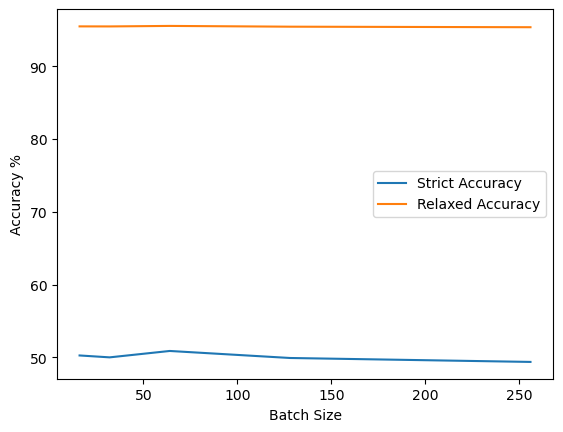

In [15]:
relaxed_accuracies = errors
plt.plot(batch_sizes, accuracies, label="Strict Accuracy")
plt.plot(batch_sizes, relaxed_accuracies, label="Relaxed Accuracy")
# plt.ylim((47,52))
plt.legend()
plt.xlabel("Batch Size")
plt.ylabel("Accuracy %")

# Testing Different Optimizers
In order to find the best optimizer to use, we tested out 3 of the most popular optimizers for our application: Adam, Stochastic Gradient Descent, and AdaGrad.

From our analysis, we found far better results for the Adam optimizer than either of the others.

In [16]:
opt_accuracies = []
opt_relaxed = []

# Adam Optimizer
print("Training with Adam Optimizer:")
model = GradePredictionModel(num_classes, vocab_sizes)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_model(model, train_loader, val_loader, loss_fn, optimizer, 10)
acc, rel = evaluate(model, test_loader)
opt_accuracies.append(acc)
opt_relaxed.append(rel)

# SGD Optimizer
print("Training with SGD Optimizer:")
model = GradePredictionModel(num_classes, vocab_sizes)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
train_model(model, train_loader, val_loader, loss_fn, optimizer, 10)
acc, rel = evaluate(model, test_loader)
opt_accuracies.append(acc)
opt_relaxed.append(rel)

# AdaGrad Optimizer
print("Training with AdaGrad Optimizer:")
model = GradePredictionModel(num_classes, vocab_sizes)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(model.parameters(), lr=0.001)
train_model(model, train_loader, val_loader, loss_fn, optimizer, 10)
acc, rel = evaluate(model, test_loader)
opt_accuracies.append(acc)
opt_relaxed.append(rel)

Training with Adam Optimizer:
Epoch [1/10], Loss: 1.4945, Val Loss: 1.3735
Epoch [2/10], Loss: 1.3204, Val Loss: 1.3047
Epoch [3/10], Loss: 1.2382, Val Loss: 1.2617
Epoch [4/10], Loss: 1.1682, Val Loss: 1.2317
Epoch [5/10], Loss: 1.1161, Val Loss: 1.2192
Epoch [6/10], Loss: 1.0692, Val Loss: 1.2194
Epoch [7/10], Loss: 1.0308, Val Loss: 1.2179
Epoch [8/10], Loss: 0.9992, Val Loss: 1.2150
Epoch [9/10], Loss: 0.9701, Val Loss: 1.2359
Epoch [10/10], Loss: 0.9425, Val Loss: 1.2431
Test Accuracy: 50.28%
Relaxed Test Accuracy: 95.51%
Training with SGD Optimizer:
Epoch [1/10], Loss: 1.7866, Val Loss: 1.6320
Epoch [2/10], Loss: 1.5900, Val Loss: 1.5704
Epoch [3/10], Loss: 1.5388, Val Loss: 1.5275
Epoch [4/10], Loss: 1.5045, Val Loss: 1.4946
Epoch [5/10], Loss: 1.4830, Val Loss: 1.4797
Epoch [6/10], Loss: 1.4607, Val Loss: 1.4593
Epoch [7/10], Loss: 1.4451, Val Loss: 1.4420
Epoch [8/10], Loss: 1.4287, Val Loss: 1.4303
Epoch [9/10], Loss: 1.4153, Val Loss: 1.4153
Epoch [10/10], Loss: 1.4009, Val 

Text(0, 0.5, 'Accuracy %')

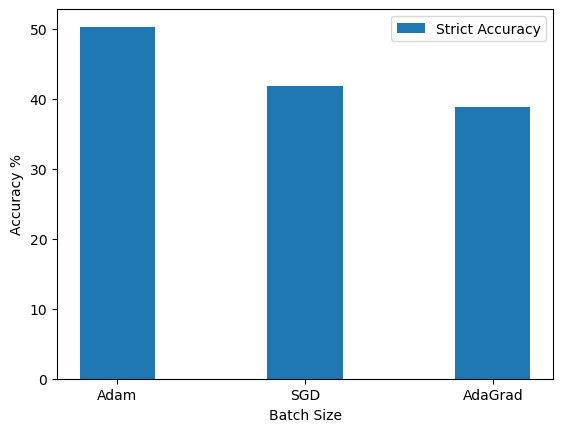

In [17]:
optimizers = ["Adam", "SGD", "AdaGrad"]
plt.bar(optimizers, opt_accuracies, width=0.4, label="Strict Accuracy")
plt.legend()
plt.xlabel("Batch Size")
plt.ylabel("Accuracy %")

# Other Hyperparameters
We have conducted a further analysis of 2 main hyperperameters: dropout rate and learning rate.

For the dropout rate we tested 5 different values 0.0, 0.1, 0.3, 0.5, 0.8 and plotted the resulting model accuracies. We found that dropout rates between 0.1 and 0.5 performed slightly better than the rest.

Next we tested 3 different learning rates: 0.1, 0.01, 0.001. Here we see that 0.1 resulted in far lower accuracy than the other 2. We concluded that 0.1 was too large of a rate, and 0.001 slightly outperformed 0.01.

In [18]:
dropouts = [0.0, 0.1, 0.3, 0.5, 0.8]
accuracies_drop = []
relaxed_drop = []
for i in range(len(dropouts)):
    print("Training with dropout value:", dropouts[i])
    model = GradePredictionModel(num_classes, vocab_sizes, dropouts[i])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_model(model, train_loader, val_loader, criterion, optimizer, 10)
    acc, rel = evaluate(model, test_loader)
    accuracies_drop.append(acc)
    relaxed_drop.append(rel)

Training with dropout value: 0.0
Epoch [1/10], Loss: 1.4656, Val Loss: 1.3499
Epoch [2/10], Loss: 1.2666, Val Loss: 1.2854
Epoch [3/10], Loss: 1.1637, Val Loss: 1.2484
Epoch [4/10], Loss: 1.0788, Val Loss: 1.2367
Epoch [5/10], Loss: 1.0070, Val Loss: 1.2341
Epoch [6/10], Loss: 0.9460, Val Loss: 1.2434
Epoch [7/10], Loss: 0.8889, Val Loss: 1.2876
Epoch [8/10], Loss: 0.8372, Val Loss: 1.3071
Epoch [9/10], Loss: 0.7885, Val Loss: 1.3471
Epoch [10/10], Loss: 0.7433, Val Loss: 1.4113
Test Accuracy: 49.47%
Relaxed Test Accuracy: 95.34%
Training with dropout value: 0.1
Epoch [1/10], Loss: 1.4699, Val Loss: 1.3525
Epoch [2/10], Loss: 1.2838, Val Loss: 1.2816
Epoch [3/10], Loss: 1.1914, Val Loss: 1.2466
Epoch [4/10], Loss: 1.1181, Val Loss: 1.2225
Epoch [5/10], Loss: 1.0582, Val Loss: 1.2274
Epoch [6/10], Loss: 1.0051, Val Loss: 1.2078
Epoch [7/10], Loss: 0.9575, Val Loss: 1.2281
Epoch [8/10], Loss: 0.9169, Val Loss: 1.2383
Epoch [9/10], Loss: 0.8797, Val Loss: 1.2704
Epoch [10/10], Loss: 0.847

Text(0, 0.5, 'Accuracy %')

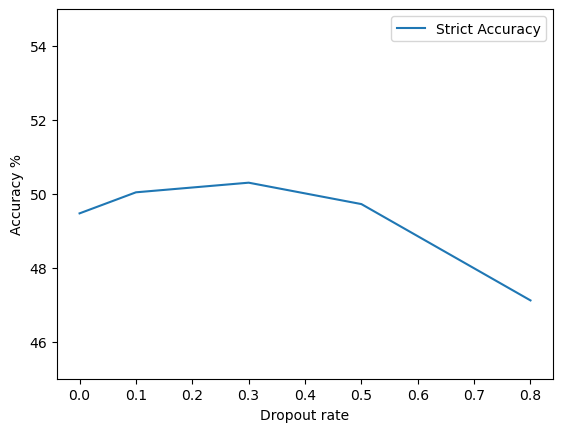

In [19]:
plt.plot(dropouts, accuracies_drop, label="Strict Accuracy")
plt.ylim((45,55))
plt.legend()
plt.xlabel("Dropout rate")
plt.ylabel("Accuracy %")

Text(0, 0.5, 'Accuracy %')

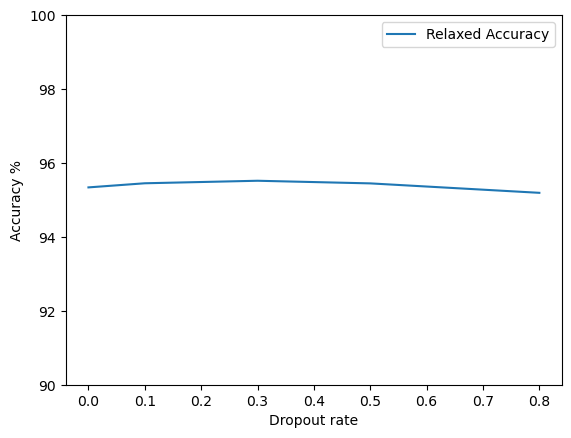

In [20]:
plt.plot(dropouts, relaxed_drop, label="Relaxed Accuracy")
plt.ylim((90, 100))
plt.legend()
plt.xlabel("Dropout rate")
plt.ylabel("Accuracy %")

In [21]:
rates = [0.1, 0.01, 0.001]
accuracies_rate = []
relaxed_rate = []
for i in range(len(rates)):
    print("Training with learning rate:", rates[i])
    model = GradePredictionModel(num_classes, vocab_sizes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=rates[i])
    train_model(model, train_loader, val_loader, criterion, optimizer, 10)
    acc, rel = evaluate(model, test_loader)
    accuracies_rate.append(acc)
    relaxed_rate.append(rel)

Training with learning rate: 0.1
Epoch [1/10], Loss: 1.7513, Val Loss: 1.6648
Epoch [2/10], Loss: 1.7321, Val Loss: 1.6707
Epoch [3/10], Loss: 1.6767, Val Loss: 1.6626
Epoch [4/10], Loss: 1.6555, Val Loss: 1.6641
Epoch [5/10], Loss: 2.0263, Val Loss: 1.6607
Epoch [6/10], Loss: 1.6507, Val Loss: 1.6679
Epoch [7/10], Loss: 1.6612, Val Loss: 1.6585
Epoch [8/10], Loss: 1.6501, Val Loss: 1.6596
Epoch [9/10], Loss: 1.6497, Val Loss: 1.6594
Epoch [10/10], Loss: 1.6503, Val Loss: 1.6648
Test Accuracy: 26.71%
Relaxed Test Accuracy: 92.04%
Training with learning rate: 0.01
Epoch [1/10], Loss: 1.4165, Val Loss: 1.2822
Epoch [2/10], Loss: 1.2106, Val Loss: 1.2355
Epoch [3/10], Loss: 1.1164, Val Loss: 1.2615
Epoch [4/10], Loss: 1.0602, Val Loss: 1.2579
Epoch [5/10], Loss: 1.0200, Val Loss: 1.2704
Epoch [6/10], Loss: 0.9892, Val Loss: 1.3799
Epoch [7/10], Loss: 0.9659, Val Loss: 1.3875
Epoch [8/10], Loss: 0.9423, Val Loss: 1.4168
Epoch [9/10], Loss: 0.9236, Val Loss: 1.4453
Epoch [10/10], Loss: 0.90

In [22]:
import os

final_model = GradePredictionModel(num_classes,  vocab_sizes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(final_model.parameters(), lr=0.001)
train_model(final_model, train_loader, val_loader, criterion, optimizer, 10)


Epoch [1/10], Loss: 1.4855, Val Loss: 1.3681
Epoch [2/10], Loss: 1.3132, Val Loss: 1.2885
Epoch [3/10], Loss: 1.2315, Val Loss: 1.2508
Epoch [4/10], Loss: 1.1675, Val Loss: 1.2285
Epoch [5/10], Loss: 1.1143, Val Loss: 1.2058
Epoch [6/10], Loss: 1.0723, Val Loss: 1.2122
Epoch [7/10], Loss: 1.0367, Val Loss: 1.2115
Epoch [8/10], Loss: 1.0022, Val Loss: 1.2042
Epoch [9/10], Loss: 0.9717, Val Loss: 1.2168
Epoch [10/10], Loss: 0.9475, Val Loss: 1.2205


In [23]:

save_path = './grade_prediction_model.pth'


# Save the entire model
torch.save(model, save_path)